In [1]:
import numpy as np 
import os, sys, time 
src_path = os.path.abspath('../../src/py_locomotion/')
sys.path.append(src_path)
import matplotlib.pyplot as plt 
import pinocchio as pin 
import robots, locomotion_tools, plotting_tools


# Load the Robot and Plotting Tools 
contact_names = ['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']
solo_path = os.path.abspath(
    '../../../robots/robot_properties/robot_properties_solo')
solo12 = robots.load_solo12_pinocchio(solo_path)  # pin.RobotWrapper object
solo12_plots = plotting_tools.RobotPlottingTools(solo12, contact_names) # plotting tools 
solo12_gaits = locomotion_tools.QuadrupedGaits(solo12, *contact_names) # some other tools 

robot forward kinematics completed 


In [2]:
SAVE_PLOTS = True 
optimized_results = np.load("trot_optimized.npz")
print optimized_results.keys()
simulated_results = np.load("trot_simulated.npz")
print simulated_results.keys()

riskXref = optimized_results['riskXs']
riskUref = optimized_results['riskUs']
riskKref = optimized_results['riskK']
riskCov = optimized_results['riskCov']

ddpXref = optimized_results['ddpXs']
ddpUref = optimized_results['ddpUs']
ddpKref = optimized_results['ddpK']
forcesRef = optimized_results['forcesRef']

""" 
    Below are some experiment results results
    states are stored as follows = [samples, solver, t, states]
    solvers = ['ddp', 'risk_sensitive']
    forces are stored as follows = [samples, solver, t, 3*contact_point] # 12 total for solo12 
"""

states_sim = simulated_results['states']
forces_sim = simulated_results['forces']
disturbances_sim = simulated_results['disturbances']

""" plot error per state per norm  """
joint_names = []
for b in solo12_plots.branch_joints:
    for j in b:
        joint_names += [j]

names_q_error = ['x', 'y', 'dz', 'qx', 'qy', 'qz'] + joint_names
names_v_error = ['vx', 'vy', 'vz', 'wx', 'wy', 'wz'] + joint_names

['riskXs', 'forcesRef', 'riskUs', 'riskK', 'ddpUs', 'ddpXs', 'ddpK', 'riskCov']
['states', 'forces', 'disturbances']


In [3]:
""" some experiment parameters """
dt = 1.e-2 
horizon = riskXref.shape[0]
print horizon
t_array = dt*np.arange(horizon)
print "Horizon = ", horizon
nSamples = states_sim.shape[0]
print "Total samples = ", nSamples

""" Computing Tracking Errors """
state_errors = np.zeros([nSamples, 2, horizon, 2*solo12.nv])
# loop to compute 
for ithSample in range(nSamples):
    for ithSolver in range(2):
        if ithSolver == 0:
            """ DDP reference errors """
            for t in range(horizon):
                state_errors[ithSample, ithSolver, t, :] = \
                np.resize(solo12_gaits.state.diff(states_sim[ithSample, ithSolver,t, :][:,None],ddpXref[t]), 2*solo12.nv)
        elif ithSolver == 1:
            """ Risk Sensitive errors """
            for t in range(horizon):
                state_errors[ithSample, ithSolver, t, :] = \
                np.resize(solo12_gaits.state.diff(states_sim[ithSample, ithSolver,t, :][:,None],riskXref[t]), 2*solo12.nv)
        else: 
            pass 
""" q error norms & v errors norm """

q_error_norms = np.zeros([nSamples, 2, horizon])
v_error_norms = np.zeros([nSamples, 2, horizon])

for ithSample in range(nSamples):
    for t in range(horizon):
        for ithSolver in range(2):
            q_error_norms[ithSample, ithSolver, t] = np.linalg.norm(state_errors[ithSample, ithSolver, t, :solo12.nv])
            v_error_norms[ithSample, ithSolver, t] = np.linalg.norm(state_errors[ithSample, ithSolver, t, solo12.nv:])

np.savez_compressed("trot_simulation_errors", state_errors = state_errors, 
        q_error_norm = q_error_norms, 
        v_error_norm = v_error_norms)

301
Horizon =  301
Total samples =  500


In [4]:
""" Compute terminal Base errors 
errors = [nSamples, solvers, [base_position, base_orientation, base_linear_vel, base_angular_vel]]
"""

accumelated_base_error = np.zeros([nSamples, 2, horizon, 4])

for ithSample in range(nSamples):
    for ithSolver in range(2):
        for t in range(horizon):
            accumelated_base_error[ithSample, ithSolver,t,0] = np.linalg.norm(state_errors[ithSample, ithSolver, t, :3])
            accumelated_base_error[ithSample, ithSolver,t, 1] = np.linalg.norm(state_errors[ithSample, ithSolver, t, 3:7])
            accumelated_base_error[ithSample, ithSolver,t, 2] = np.linalg.norm(state_errors[ithSample, ithSolver, t, solo12.nv:solo12.nv + 3])
            accumelated_base_error[ithSample, ithSolver,t, 3] = np.linalg.norm(state_errors[ithSample, ithSolver, t, solo12.nv+3:solo12.nv+6])


In [5]:
nfailed_ddp = 0
nfailed_risk = 0
success_index_risk = []
success_index_ddp = []
error_threshold = .3 # threshold on base velocity to consider as not a successful pass 
for ithSample in range(nSamples):
    if np.any(np.isnan(accumelated_base_error[ithSample, 1,:,0])) or np.any(accumelated_base_error[ithSample, 1,:,2]>error_threshold):
        nfailed_risk +=1  
    else:
        success_index_risk += [ithSample]
    
    if np.any(np.isnan(accumelated_base_error[ithSample, 0,:,0])) or np.any(accumelated_base_error[ithSample, 0,:,2]>error_threshold):
        nfailed_ddp +=1  
    else:
        success_index_ddp += [ithSample]
    
print "total ddp failed simulations = ", nfailed_ddp
print "total risk failed simulations = ", nfailed_risk



total ddp failed simulations =  263
total risk failed simulations =  175


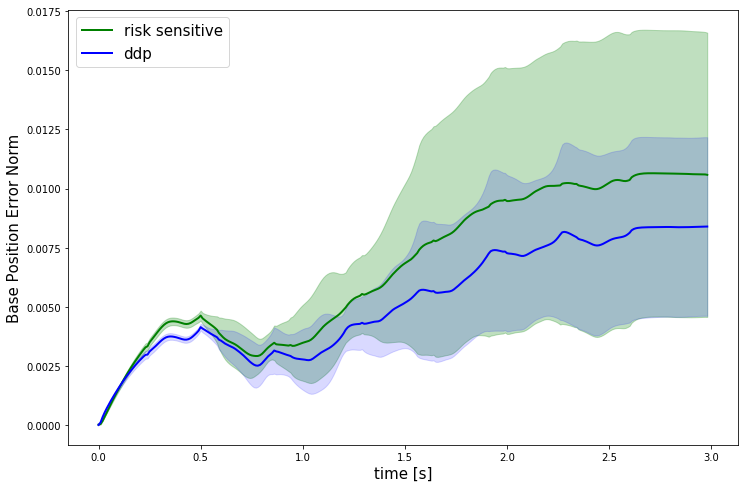

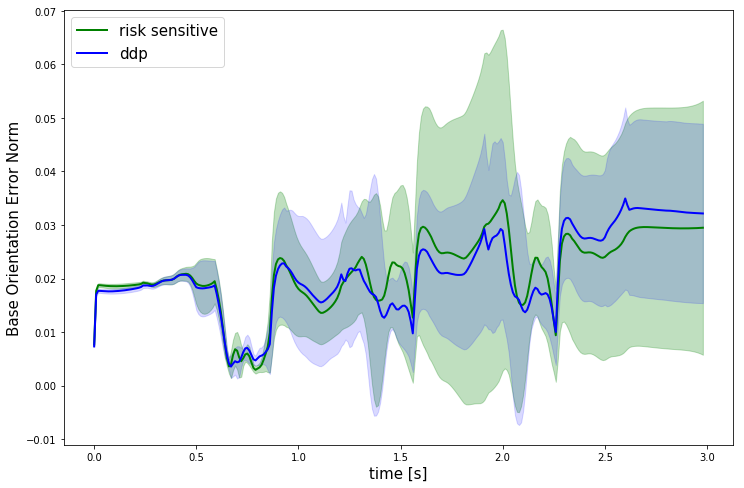

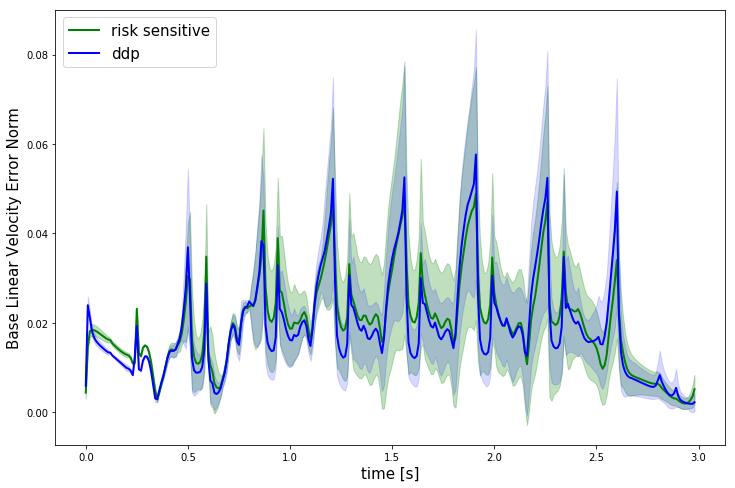

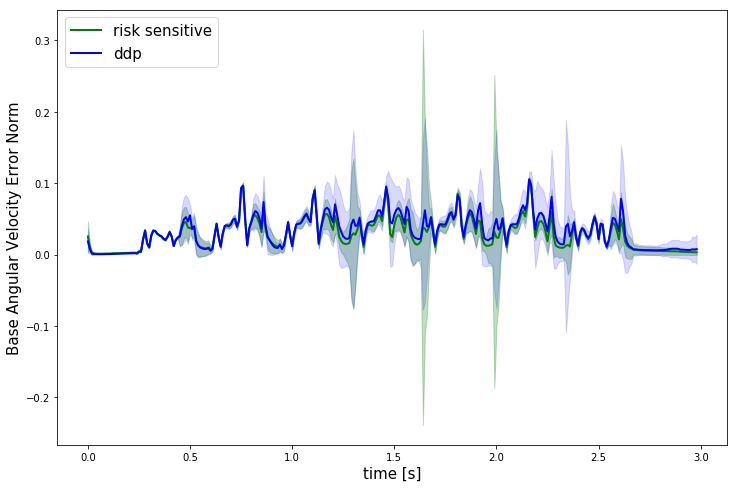

In [23]:
# here compute the mean and standard deviation 
risk_stats = np.zeros([horizon, 2,4])
ddp_stats = np.zeros([horizon, 2,4])

for i in range(4):
    ddp_stats[:,0,i] = np.mean(accumelated_base_error[success_index_ddp, 0,:,i], axis = 0)  
    ddp_stats[:,1,i] = np.std(accumelated_base_error[success_index_ddp, 0,:,i], axis = 0) 
    risk_stats[:,0,i] = np.mean(accumelated_base_error[success_index_risk, 1,:,i], axis = 0) 
    risk_stats[:,1,i] = np.std(accumelated_base_error[success_index_risk, 1,:,i], axis = 0) 

    
plot_horizon = horizon -2
plot_opacity = 0.2


component_name = ['Position', 'Orientation', 'Linear Velocity', 'Angular Velocity']
for i in range(4):
    plotTitle = 'Base '+ component_name[i] + ' Error Norm'
    plt.figure(plotTitle, figsize=(12,8))
    plt.plot(t_array[:plot_horizon],risk_stats[:plot_horizon,0, i], 'g', alpha=1., 
             linewidth=2., label='risk sensitive')
    plt.fill_between(t_array[:plot_horizon],risk_stats[:plot_horizon,0, i]-risk_stats[:plot_horizon,1, i], 
                     risk_stats[:plot_horizon,0, i]+risk_stats[:plot_horizon,1, i], alpha=.25, color='g')
    plt.plot(t_array[:plot_horizon],ddp_stats[:plot_horizon,0, i], 'b', alpha=1.,
             linewidth=2., label='ddp')
    plt.fill_between(t_array[:plot_horizon],ddp_stats[:plot_horizon,0, i]-ddp_stats[:plot_horizon,1, i], 
                     ddp_stats[:plot_horizon,0, i]+ddp_stats[:plot_horizon,1, i], alpha=.15, color='b')
    plt.legend(loc='upper left', fontsize=15.)
    plt.xlabel('time [s]', fontsize=15.)
    plt.ylabel(plotTitle, fontsize=15.)
#     plt.title(plotTitle)
    if SAVE_PLOTS:
        plt.savefig(plotTitle+".pdf")



In [ ]:
""" Plot base error norms fort samples that don't end with Nan that is complete failure """


# plt.figure("base position error norms", figsize=(12,8))
# for ithSample in success_index_risk:
#     if ithSample == success_index_risk[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 0], 'g', linewidth=.5, label="$\delta q^{b}$ Risk") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 0], 'g', linewidth=.5)  
        
# for ithSample in success_index_ddp:
#     if ithSample == success_index_ddp[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 0], 'b', linewidth=.5,alpha=plot_opacity , label="$\delta q^{b}$ DDP") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 0], 'b', linewidth=.5,alpha=plot_opacity)  
        
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig("base_position_errors.pdf")
    
# plt.figure("base linear velocity error norms", figsize=(12,8))
# for ithSample in success_index_risk:
#     if ithSample == success_index_risk[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 2], 'g', linewidth=.5, label="$\delta v^{b}$ Risk") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 2], 'g', linewidth=.5)  
        
# for ithSample in success_index_ddp:
#     if ithSample == success_index_ddp[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 2], 'b', linewidth=.5,alpha=plot_opacity, label="$\delta v^{b}$ DDP") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 2], 'b', linewidth=.5,alpha=plot_opacity)  
        
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig("base_linear_velocity_errors.pdf")
    
# plt.figure("base orientation error norms", figsize=(12,8))
# for ithSample in success_index_risk:
#     if ithSample == success_index_risk[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 1], 'g', linewidth=.5, label="$\delta q^{b}$ Risk") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 1], 'g', linewidth=.5)  
        
# for ithSample in success_index_ddp:
#     if ithSample == success_index_ddp[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 1], 'b', linewidth=.5,alpha=plot_opacity, label="$\delta q^{or}$ DDP") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 1], 'b', linewidth=.5,alpha=plot_opacity)  
        
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig("base_orientation_errors.pdf")

# plt.figure("base angular velocity error norms", figsize=(12,8))
# for ithSample in success_index_risk:
#     if ithSample == success_index_risk[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 3], 'g', linewidth=.5, label="$\delta v^{or}$ Risk") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 1, :plot_horizon, 3], 'g', linewidth=.5)  
        
# for ithSample in success_index_ddp:
#     if ithSample == success_index_ddp[0]:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 3], 'b', linewidth=.5,alpha=plot_opacity, label="$\delta v^{or}$ DDP") 
#     else:
#         plt.plot(t_array[:plot_horizon],accumelated_base_error[ithSample, 0, :plot_horizon, 3], 'b', linewidth=.5,alpha=plot_opacity)  
        
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig("base_angular_velocity_errors.pdf")

In [ ]:
""" Plot error norms for q and v for the passes that don't end with Nan that is complete failure """
plt.figure("q error norms", figsize=(12,8))
for ithSample in success_index_risk:
    if ithSample == success_index_risk[0]:
        plt.plot(t_array[:plot_horizon],q_error_norms[ithSample, 1, :plot_horizon], 'g', linewidth=.5, label="$\delta q$ Risk") 
    else:
        plt.plot(t_array[:plot_horizon],q_error_norms[ithSample, 1, :plot_horizon], 'g', linewidth=.5)  
        
for ithSample in success_index_ddp:
    if ithSample == success_index_ddp[0]:
        plt.plot(t_array[:plot_horizon],q_error_norms[ithSample, 0, :plot_horizon], 'b', linewidth=.5,alpha=plot_opacity, label="$\delta q$ DDP") 
    else:
        plt.plot(t_array[:plot_horizon],q_error_norms[ithSample, 0, :plot_horizon], 'b', linewidth=.5,alpha=plot_opacity)  
        
plt.legend()
    
plt.figure("v error norms", figsize=(12,8))
for ithSample in success_index_risk:
    if ithSample == success_index_risk[0]:
        plt.plot(t_array[:plot_horizon],v_error_norms[ithSample, 1, :plot_horizon], 'g', linewidth=.5, label="$\delta \dot{q}$ Risk") 
    else:
        plt.plot(t_array[:plot_horizon],v_error_norms[ithSample, 1, :plot_horizon], 'g', linewidth=.5)  
        
for ithSample in success_index_ddp:
    if ithSample == success_index_ddp[0]:
        plt.plot(t_array[:plot_horizon],v_error_norms[ithSample, 0, :plot_horizon], 'b', linewidth=.5,alpha=plot_opacity, label="$\delta \dot{q}$ DDP") 
    else:
        plt.plot(t_array[:plot_horizon],v_error_norms[ithSample, 0, :plot_horizon], 'b', linewidth=.5,alpha=plot_opacity)  
        
plt.legend()

In [ ]:
# """ Plot contact forces per contact for succeeding samples"""
# plot_opacity = 0.5
# for i, cname in enumerate(contact_names):
#     plt.figure(cname + " Normal Contact Forces", figsize=(12,8))
    
#     for ithSample in success_index_risk:
#         if ithSample == success_index_risk[0]:
#             plt.plot(t_array[:plot_horizon],forces_sim[ithSample, 1, :plot_horizon, 3*i+2], 'g', linewidth=.5, label=cname+ " $f_n$ Risk") 
#         else:
#             plt.plot(t_array[:plot_horizon],forces_sim[ithSample, 1, :plot_horizon, 3*i+2], 'g', linewidth=.5)  

#     for ithSample in success_index_ddp:
#         if ithSample == success_index_ddp[0]:
#             plt.plot(t_array[:plot_horizon],forces_sim[ithSample, 0, :plot_horizon, 3*i+2], 'r', linewidth=.5,alpha=plot_opacity , label=cname+" $f_n$ DDP") 
#         else:
#             plt.plot(t_array[:plot_horizon],forces_sim[ithSample, 0, :plot_horizon, 3*i+2], 'r', linewidth=.5,alpha=plot_opacity)  
    
#     plt.plot(t_array[:plot_horizon],forcesRef[:plot_horizon,3*i+2], 'b--', linewidth=2., label="$f_n$ Ref")
#     plt.legend()
#     plt.ylim([-1., 25.])
#     if SAVE_PLOTS:
#         plt.savefig(cname + "_fn_tracking.pdf")

In [ ]:
# kpRisk = []
# kdRisk = []
# kpDDP  = []
# kdDDP  = []
# N = ddpKref.shape[0]
# for t in range(N):
#     kpRisk += [np.linalg.norm(riskKref[t,:,:solo12.nv])]
#     kdRisk += [np.linalg.norm(riskKref[t,:,solo12.nv:])]
#     kpDDP  += [np.linalg.norm(ddpKref[t,:,:solo12.nv])]
#     kdDDP  += [np.linalg.norm(ddpKref[t,:,solo12.nv:])]

  




# plt.figure('Kp ddp')
# plt.plot(dt*np.arange(N), kpDDP, 'r', linewidth=2., label="$| K_p |$  DDP")
# plt.plot(dt*np.arange(N), kpRisk, 'g', linewidth=2., label="$| K_p |$  Risk")
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig('trot_kp.pdf')


# plt.figure('Kd ddp')
# plt.plot(dt*np.arange(N), kdDDP, 'r', linewidth=2., label="$| K_d |$  DDP")
# plt.plot(dt*np.arange(N), kdRisk, 'g', linewidth=2., label="$| K_d |$  Risk")
# plt.legend()
# if SAVE_PLOTS:
#     plt.savefig('trot_kd.pdf')
